# Imports

In [1]:
import torch
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Seed {seed}")

set_seed(42)

Seed 42


# Data extraction and preprocessing

In [3]:
# Load the CSV
csv_file = "../data/ETTh1.csv"
df = pd.read_csv(csv_file)
print(df.head())

                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [4]:
window_length = 168
step_size = 1

In [5]:
# 1. Order by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

def extract_windows(df, window_len, step):
    windows = []
    timestamps = []
    
    # Drop non-numeric columns for window extraction
    numeric_df = df.drop(columns=["date"])
    
    for i in range(step - 1, len(df) - window_len + 1, step):
        # Window of numeric features
        window = numeric_df.iloc[i:i+window_len].values
        windows.append(window)
        
        # Associate timestamps
        timestamps.append(df["date"].iloc[i:i+window_len].values)
    
    return np.array(windows), np.array(timestamps)

all_windows, all_timestamps = extract_windows(df, window_length, step_size)

X = all_windows  # shape: (num_samples, window_length, num_features)
meta_time = all_timestamps  # metadata: array of associated dates

print("Shape of X:", X.shape)               # (num_samples, window_length, num_features)
print("Shape of meta_time:", meta_time.shape)  # (num_samples, window_length)


Shape of X: (17253, 168, 7)
Shape of meta_time: (17253, 168)


In [6]:
# Ensure the dataframe is sorted by date
df["date"] = pd.to_datetime(df["date"])

# Define time boundaries
start_date = df["date"].min()
train_end = start_date + pd.DateOffset(months=12)
val_end = train_end + pd.DateOffset(months=4)
test_end = val_end + pd.DateOffset(months=4)

# Create masks for each split
train_mask = [all(d < train_end for d in window) for window in meta_time]
val_mask   = [all((d >= train_end) and (d < val_end) for d in window) for window in meta_time]
test_mask  = [all((d >= val_end) and (d < test_end) for d in window) for window in meta_time]

# Apply the masks
X_train = X[train_mask]
X_val   = X[val_mask]
X_test  = X[test_mask]

meta_train = [m for m, flag in zip(meta_time, train_mask) if flag]
meta_val   = [m for m, flag in zip(meta_time, val_mask) if flag]
meta_test  = [m for m, flag in zip(meta_time, test_mask) if flag]

print(len(X_train), len(X_val), len(X_test))

8593 2785 2713


# Encoder and Decoder

Our goal was to build an encoder-decoder model able to learn a compressed representaion of the input time series, so to allow a more efficient search of similar time series in a smaller dimensional space, speeding up the task of finding k nearest neighbours. </br> The encoder gets as input a tensor of shape (batch_size, seq_len, num_features) and compresses it into a tensor of shape (batch_size, embedding_dim), while the decoder takes the output of the encoder and tries to reconstruct the original input. 

In [7]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation  # full causal
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)

        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)

        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.relu2, self.dropout2,
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.net(x)
        if out.shape != res.shape:
            # Align time dimension by cropping the residual (this might be necessary in some edge cases)
            min_len = min(out.size(-1), res.size(-1))
            out = out[..., :min_len]
            res = res[..., :min_len]
        return self.relu(out + res)

# Encoder
class TCNEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_dim if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))
        self.tcn = nn.Sequential(*layers)

        # Projection from [B, C, T] to [B, emb_dim]
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(num_channels[-1], emb_dim)

    def forward(self, x):
        # x: [B, T, D] → [B, D, T]
        x = x.permute(0, 2, 1)
        x = self.tcn(x)  # [B, C, T]
        x = self.pool(x).squeeze(-1)  # [B, C]
        x = self.project(x)  # [B, emb_dim]
        return x

# Decoder
class TCNDecoder(nn.Module):
    def __init__(self, emb_dim, output_dim, seq_len, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.seq_len = seq_len
        self.output_dim = output_dim

        # Project embedding back to a sequence shape: [B, C, T]
        self.expand = nn.Linear(emb_dim, num_channels[0] * seq_len)

        layers = []
        for i in range(len(num_channels) - 1):
            in_ch = num_channels[i]
            out_ch = num_channels[i + 1]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, dropout))

        self.tcn = nn.Sequential(*layers)
        self.out_proj = nn.Conv1d(num_channels[-1], output_dim, kernel_size=1)

    def forward(self, x):
        # x: [B, emb_dim] → [B, C0, T]
        x = self.expand(x)  # [B, C0 * T]
        x = x.view(x.size(0), -1, self.seq_len)  # [B, C0, T]
        x = self.tcn(x)  # [B, Cn, T]
        x = self.out_proj(x)  # [B, D, T]
        return x.permute(0, 2, 1)  # [B, T, D]
    
class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim, seq_len, channels, kernel_size=3, dropout=0.2):
        super().__init__()
        self.encoder = TCNEncoder(input_dim, emb_dim, channels, kernel_size, dropout)
        self.decoder = TCNDecoder(emb_dim, input_dim, seq_len, channels[::-1], kernel_size, dropout)

    def forward(self, x, only_encoder = False):
        # x: [B, T, D]
        z = self.encoder(x)       # [B, emb_dim]
        if only_encoder:
            return z
        x_recon = self.decoder(z) # [B, T, D]
        return x_recon

In [8]:
# Compute the statistics of the train dataset and normalize with respect to it 

mean = X_train.mean(axis=(0, 1), keepdims=True)  # shape (1, 1, num_features)
std = X_train.std(axis=(0, 1), keepdims=True)

X_train = (X_train - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

print(mean, std)

[[[ 7.92180443  2.00092862  5.06570627  0.74090102  2.77964725
    0.77437088 17.06679531]]] [[[5.83873226 2.08181492 5.54750667 1.92983391 1.02520879 0.62911197
   9.161666  ]]]


In [9]:
# Convert into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Dataset & DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=batch_size)

# Model training

In [10]:
emb_dim = 256
channels = [32, 32, 32, 32, 32]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCNAutoencoder(input_dim=7, emb_dim=emb_dim, seq_len=168, channels=channels).to(device)

def count_parameters(model):
    """Counts the number of trainable parameters in the model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameters: {count_parameters(model):,}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ------------------------------
# Contrastive + Metric Preservation Autoencoder
# ------------------------------

def cosine_similarity_matrix(z):
    """Returns the cosine similarity matrix between all samples in the batch."""
    z = F.normalize(z, p=2, dim=1)
    return torch.mm(z, z.T)

def metric_preserving_loss(x, z):
    """
    Penalizes the difference between cosine similarities in the original and latent spaces.
    Both are normalized within the batch.
    """
    with torch.no_grad():
        sim_x = cosine_similarity_matrix(x.flatten(1))  # similarity in input space (batch only)
    sim_z = cosine_similarity_matrix(z)
    return F.mse_loss(sim_z, sim_x)

# --- Contrastive loss (SimCLR-style) ---
def contrastive_loss(z1, z2, temperature=0.3):
    """Computes a SimCLR-style contrastive loss between two augmented views."""
    z = torch.cat([z1, z2], dim=0)
    sim = torch.mm(z, z.T) / temperature

    # Mask to exclude self-similarity
    mask = torch.eye(sim.size(0), device=z.device).bool()
    sim = sim.masked_fill(mask, -1e9)

    # Labels: each i in [0, B-1] has positive i+B, and vice versa
    labels = torch.cat([
        torch.arange(z1.size(0), z1.size(0) * 2),
        torch.arange(0, z1.size(0))
    ]).to(z.device)

    loss = F.cross_entropy(sim, labels)
    return loss

# ------------------------------
# Training loop with 3 losses
# ------------------------------

lambda_contrast = 0.02
lambda_sim = 0.3
temperature = 0.2

epochs = 100
best_loss = float("inf")
encoder_path = "encoder.pth"

patience = 10
wait = 0
best_epoch = 0

# --- Evaluation helper ---
def evaluate(model, loader):
    """Evaluates model reconstruction MSE on a given dataloader."""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for (x,) in loader:
            x = x.to(device)
            x_hat = model(x)
            loss = loss_fn(x_hat, x)
            total_loss += loss.item()
    return total_loss / len(loader)

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0

    for (x,) in train_loader:
        x = x.to(device)

        # Light augmentations
        noise = torch.randn_like(x) * 0.02
        scale = 1.0 + torch.randn_like(x) * 0.03
        x1 = x * scale + noise
        x2 = x * (1.0 - 0.5 * torch.randn_like(x))  # second view

        # Forward pass
        x_hat = model(x)
        z1 = model.encoder(x1)
        z2 = model.encoder(x2)

        # Compute losses
        recon_loss = F.mse_loss(x_hat, x)
        cont_loss = contrastive_loss(z1, z2, temperature)
        sim_loss = metric_preserving_loss(x, z1)

        if cont_loss == float("inf"):
            print("Infinite Contrastive Loss")
        if sim_loss == float("inf"):
            print("Infinite Similarity Loss")

        total_loss = recon_loss + lambda_contrast * cont_loss + lambda_sim * sim_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()

    train_loss /= len(train_loader)
    val_loss = evaluate(model, val_loader)
    test_loss = evaluate(model, test_loader)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        wait = 0
        torch.save(model.state_dict(), encoder_path)
        print(f" Model saved successfully at epoch {epoch}.")
    else:
        wait += 1
        if wait >= patience:
            print(f"\n Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.6f} | Val MSE: {val_loss:.6f} | Test MSE: {test_loss:.6f}")

print(f"\n Best validation loss: {best_loss:.6f} at epoch {best_epoch}.")


Model parameters: 1,444,039
 Model saved successfully at epoch 1.
Epoch 001 | Train Loss: 0.575675 | Val MSE: 0.966982 | Test MSE: 0.728405
Epoch 002 | Train Loss: 0.463943 | Val MSE: 0.972341 | Test MSE: 0.765365
Epoch 003 | Train Loss: 0.437543 | Val MSE: 0.991260 | Test MSE: 0.779506
 Model saved successfully at epoch 4.
Epoch 004 | Train Loss: 0.413158 | Val MSE: 0.866436 | Test MSE: 0.684515
 Model saved successfully at epoch 5.
Epoch 005 | Train Loss: 0.365090 | Val MSE: 0.775597 | Test MSE: 0.713125
 Model saved successfully at epoch 6.
Epoch 006 | Train Loss: 0.295664 | Val MSE: 0.692370 | Test MSE: 0.664688
 Model saved successfully at epoch 7.
Epoch 007 | Train Loss: 0.253126 | Val MSE: 0.617616 | Test MSE: 0.590763
 Model saved successfully at epoch 8.
Epoch 008 | Train Loss: 0.234069 | Val MSE: 0.610248 | Test MSE: 0.608228
 Model saved successfully at epoch 9.
Epoch 009 | Train Loss: 0.222070 | Val MSE: 0.608656 | Test MSE: 0.589238
 Model saved successfully at epoch 10.
E

# Save the models

In [11]:
emb_dim = 256
channels = [32, 32, 32, 32, 32]
model = TCNAutoencoder(input_dim=7, emb_dim=emb_dim, seq_len=168, channels=channels)

model.load_state_dict(torch.load("encoder.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

print("Models reloaded successfully.")

Models reloaded successfully.


C:\Users\saver\AppData\Local\Temp\ipykernel_11876\2487370983.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("encoder.pth"))


In [12]:
import torch
import torch.nn.functional as F
from sklearn.metrics import pairwise_distances
import numpy as np

def encode_in_batches(model, X, device, batch_size=256):
    """Encodes X in mini-batches to avoid out-of-memory (OOM) errors."""
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = torch.tensor(X[i:i+batch_size], dtype=torch.float32).to(device)
            emb = model.encoder(batch)
            embeddings.append(emb.cpu())
            del batch, emb
            torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0).numpy()

# ---- Computation ----
train_len, val_len, test_len = len(X_train), len(X_val), len(X_test)

# ===========================
# ORIGINAL DATA PREPARATION
# ===========================
# If they are PyTorch tensors → convert to NumPy arrays
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

X_train_orig = to_numpy(X_train)
X_val_norm_np = to_numpy(X_val)
X_test_norm_np = to_numpy(X_test)

# Concatenate validation and test sets
X_valtest_orig = np.concatenate([X_val_norm_np, X_test_norm_np], axis=0)

# ===========================
# FLATTEN TIME SERIES
# ===========================
# If shape is (N, T, D) → reshape to (N, T*D)
X_train_flat = X_train_orig.reshape(X_train_orig.shape[0], -1)
X_valtest_flat = X_valtest_orig.reshape(X_valtest_orig.shape[0], -1)

# ===========================
# ENCODED ARRAYS (GPU → mini-batches)
# ===========================
X_train_enc = encode_in_batches(model, X_train_orig, device)
X_valtest_enc = encode_in_batches(model, X_valtest_orig, device)

# ===========================
# COSINE SIMILARITY
# ===========================
sim_original = 1 - pairwise_distances(X_valtest_flat, X_train_flat, metric="cosine")
sim_encoded  = 1 - pairwise_distances(X_valtest_enc, X_train_enc, metric="cosine")

print("Shapes:")
print("  sim_original:", sim_original.shape)
print("  sim_encoded :", sim_encoded.shape)

# ===========================
# L1 DIFFERENCE CALCULATION
# ===========================
sim_original_t = torch.tensor(sim_original, dtype=torch.float32)
sim_encoded_t  = torch.tensor(sim_encoded, dtype=torch.float32)

l1_diff = torch.nn.L1Loss()(sim_original_t, sim_encoded_t)
print(f"L1 difference between similarity matrices: {l1_diff.item():.6f}")


Shapes:
  sim_original: (5498, 8593)
  sim_encoded : (5498, 8593)
L1 difference between similarity matrices: 0.106833


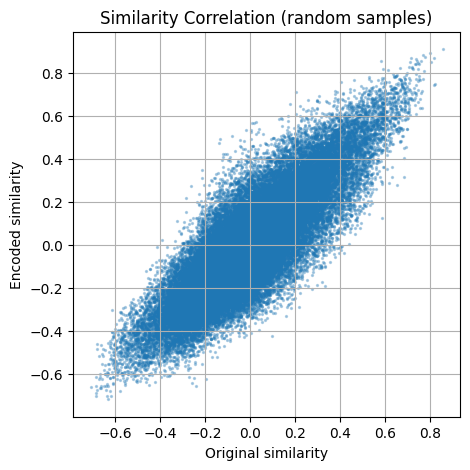

Pearson Correlation: 0.838


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# for i in range(100):
# Sample 50k random couples
n_samples = 50_000
rows = np.random.randint(0, sim_original.shape[0], n_samples)
cols = np.random.randint(0, sim_original.shape[1], n_samples)
sim_o = sim_original[rows, cols]
sim_e = sim_encoded[rows, cols]

plt.figure(figsize=(5,5))
plt.scatter(sim_o, sim_e, s=2, alpha=0.3)
plt.xlabel("Original similarity")
plt.ylabel("Encoded similarity")
plt.title("Similarity Correlation (random samples)")
plt.grid(True)
plt.show()

corr = np.corrcoef(sim_o, sim_e)[0,1]
print(f"Pearson Correlation: {corr:.3f}")


In [14]:
def topk_neighbors_in_batches(X_query, X_ref, k=3, batch_size=512):
    """
    Computes the top-k nearest neighbors for X_query with respect to X_ref in mini-batches,
    avoiding the need to construct the full similarity matrix.
    Returns an array (n_query, k) of indices.
    """
    n_query = X_query.shape[0]
    topk_indices = np.empty((n_query, k), dtype=np.int32)

    for start in range(0, n_query, batch_size):
        end = min(start + batch_size, n_query)
        sim = 1 - pairwise_distances(X_query[start:end], X_ref, metric="cosine")
        topk_indices[start:end] = np.argsort(-sim, axis=1)[:, :k]
        del sim
    return topk_indices


def compute_topk_set_match(X_train_orig, X_valtest_orig,
                           X_train_enc, X_valtest_enc,
                           k=3, batch_size=512):
    """
    Compares the top-k neighbors as sets (ignoring order).
    """
    topk_orig = topk_neighbors_in_batches(X_valtest_orig, X_train_orig, k, batch_size)
    topk_enc  = topk_neighbors_in_batches(X_valtest_enc,  X_train_enc,  k, batch_size)

    # Compute overlap
    overlaps = np.array([
        len(set(topk_orig[i]).intersection(set(topk_enc[i]))) / k
        for i in range(len(topk_orig))
    ])
    match_rate = np.mean(overlaps == 1.0)
    avg_overlap = overlaps.mean()
    return match_rate, avg_overlap


# ===== EXECUTION =====
match_rate, avg_overlap = compute_topk_set_match(
    X_train_flat, X_valtest_flat, X_train_enc, X_valtest_enc, k=3, batch_size=256
)

print(f"Top-3 set match rate: {match_rate:.4f}")
print(f"Average top-3 overlap: {avg_overlap:.4f}")

Top-3 set match rate: 0.0069
Average top-3 overlap: 0.1007
